In [ ]:
import tensorflow as tf

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import emcee
from chainconsumer import ChainConsumer
#import corner
from scipy import optimize as op
from tensorflow import keras


### Weiner Filter
$$P(s,C_s|d,C_n) \propto \, (2\pi C_s)^{-1/2}\, \exp\left\{-\frac12 \frac{[d-s]^2}{C_n} \right\}
e^{-s^2/2C_s}.
$$
Let's first consider the case where $C_s$ is known (as is $C_n$). Then the maximum value of the posterior for the signal $s$ given the data $d$ can be obtained using Bayes theorem. This is the Weiner filter:
$$ s_{Weiner} = \frac{C_s}{C_s+C_n}\, d .$$

Let's see how well this estimator does in a simple 1-pixel experiment. Both signal and noise are drawn from a Gaussian distribution. We can see analytically that the expected value of $s_{Weiner}$ is
$$ \langle s_W \rangle_N = \frac{C_s}{C_s+C_n}\, s_{true}. $$
where the subscript $N$ denotes an average over all noise realizations, but keeping $s$ fixed. Let's do 10000 runs of this for several different values of $C_s$ (always choosing $C_n=1$).


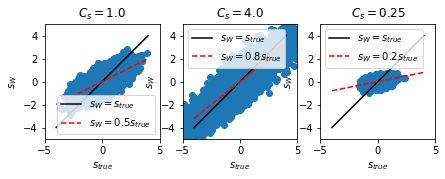

In [2]:
np.random.seed(seed=41)
sarr=[]
weiner=[]
CS=1.
for i in range(10000):
    n=np.random.normal(size=1)
    s=np.sqrt(CS)*np.random.normal(size=1)
    sarr.append(s)
    d=s+n
    w=CS/(1.+CS)
    weiner.append(d*w)
#plt.plot([1, 2, 3])
# now create a subplot which represents the top plot of a grid
# with 2 rows and 1 column. Since this subplot will overlap the
# first, the plot (and its axes) previously created, will be removed
plt.figure(figsize=(7,7)) 
plt.subplot(131)
ax = plt.gca() #you first need to get the axis handle
ax.set_aspect(1.) #sets the height to width ratio to 1.5. 
plt.scatter(sarr,weiner)  
plt.plot([-4,4],[-4,4],'-k',label='$s_W=s_{true}$')
plt.plot([-4,4],[-4*CS/(1.+CS),4*CS/(1.+CS)],'--r',label='$s_W=$'+str(w)+'$s_{true}$')
plt.axis([-5,5,-5,5])
plt.xlabel('$s_{true}$')
plt.ylabel('$s_W$')
plt.title('$C_s=$'+str(CS))
plt.legend()

### Higher CS
sarr=[]
weiner=[]
CS=4.
for i in range(10000):
    n=np.random.normal(size=1)
    s=np.sqrt(CS)*np.random.normal(size=1)
    sarr.append(s)
    d=s+n
    w=CS/(1.+CS)
    weiner.append(d*w)
#plt.plot([1, 2, 3])
# now create a subplot which represents the top plot of a grid
# with 2 rows and 1 column. Since this subplot will overlap the
# first, the plot (and its axes) previously created, will be removed
#plt.figure(figsize=(7,7)) 
plt.subplot(132)
ax = plt.gca() #you first need to get the axis handle
ax.set_aspect(1.) #sets the height to width ratio to 1.5. 
plt.axis([-5,5,-5,5])
plt.scatter(sarr,weiner)  
plt.plot([-4,4],[-4,4],'-k',label='$s_W=s_{true}$')
plt.plot([-4,4],[-4*CS/(1.+CS),4*CS/(1.+CS)],'--r',label='$s_W=$'+str(w)+'$s_{true}$')
plt.xlabel('$s_{true}$')
plt.ylabel('$s_W$')
plt.title('$C_s=$'+str(CS))
plt.legend()

### Lower CS
sarr=[]
weiner=[]
CS=.25
for i in range(10000):
    n=np.random.normal(size=1)
    s=np.sqrt(CS)*np.random.normal(size=1)
    sarr.append(s)
    d=s+n
    w=CS/(1.+CS)
    weiner.append(d*w)
#plt.plot([1, 2, 3])
# now create a subplot which represents the top plot of a grid
# with 2 rows and 1 column. Since this subplot will overlap the
# first, the plot (and its axes) previously created, will be removed
#plt.figure(figsize=(7,7)) 
plt.subplot(133)
plt.axis([-5,5,-5,5])
ax = plt.gca() #you first need to get the axis handle
ax.set_aspect(1.) #sets the height to width ratio to 1.5. 
plt.scatter(sarr,weiner)  
plt.plot([-4,4],[-4,4],'-k',label='$s_W=s_{true}$')
plt.plot([-4,4],[-4*CS/(1.+CS),4*CS/(1.+CS)],'--r',label='$s_W=$'+str(w)+'$s_{true}$')
plt.xlabel('$s_{true}$')
plt.ylabel('$s_W$')
plt.title('$C_s=$'+str(CS))
plt.legend()

-0.012337227072585525 0.44904377563100534 0.5010648274277341


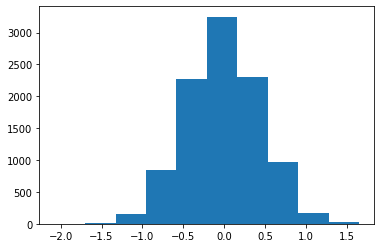

In [3]:
weiner=np.array(weiner)
sarr=np.array(sarr)
diff=weiner-sarr
plt.hist(diff)
print(np.mean(diff),np.std(diff),np.std(sarr))

This is odd: $s_W$ is the maximum posterior of the signal, the most likely value of the signal given the data ... and yet it appears biased: it gives the wrong expected value for the signal. In fact, it appears that simply using the data itself as an estimator would do better. Let's check that

-0.03303932209048627 1.0318666629285675 0.5115723962475327


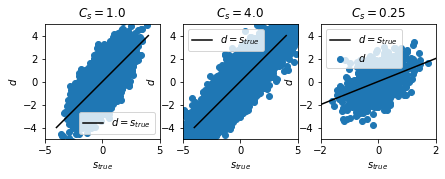

In [4]:
np.random.seed(seed=41)
sarr=[]
weiner=[]
CS=1.
for i in range(10000):
    n=np.random.normal(size=1)
    s=np.sqrt(CS)*np.random.normal(size=1)
    sarr.append(s)
    d=s+n
    w=CS/(1.+CS)
    weiner.append(d)
#plt.plot([1, 2, 3])
# now create a subplot which represents the top plot of a grid
# with 2 rows and 1 column. Since this subplot will overlap the
# first, the plot (and its axes) previously created, will be removed
plt.figure(figsize=(7,7)) 
ax=plt.subplot(131)
plt.axis([-5,5,-5,5])
#ax = plt.gca() #you first need to get the axis handle
ax.set_aspect(1.) #sets the height to width ratio to 1.5. 
plt.scatter(sarr,weiner)  
plt.plot([-4,4],[-4,4],'-k',label='$d=s_{true}$')
#plt.plot([-4,4],[-4*CS/(1.+CS),4*CS/(1.+CS)],'--r',label='$s_W=$'+str(w)+'$s_{true}$')
plt.xlabel('$s_{true}$')
plt.ylabel('$d$')
plt.title('$C_s=$'+str(CS))
plt.legend()

### Higher CS
sarr=[]
weiner=[]
CS=4.
for i in range(10000):
    n=np.random.normal(size=1)
    s=np.sqrt(CS)*np.random.normal(size=1)
    sarr.append(s)
    d=s+n
    w=CS/(1.+CS)
    weiner.append(d)
#plt.plot([1, 2, 3])
# now create a subplot which represents the top plot of a grid
# with 2 rows and 1 column. Since this subplot will overlap the
# first, the plot (and its axes) previously created, will be removed
#plt.figure(figsize=(7,7)) 
plt.subplot(132)
plt.axis([-5,5,-5,5])
ax = plt.gca() #you first need to get the axis handle
ax.set_aspect(1.) #sets the height to width ratio to 1.5. 
plt.scatter(sarr,weiner)  
plt.plot([-4,4],[-4,4],'-k',label='$d=s_{true}$')
#plt.plot([-4,4],[-4*CS/(1.+CS),4*CS/(1.+CS)],'--r',label='$s_W=$'+str(w)+'$s_{true}$')
plt.xlabel('$s_{true}$')
plt.ylabel('$d$')
plt.title('$C_s=$'+str(CS))
plt.legend()

### Lower CS
sarr=[]
weiner=[]
CS=.25
narr=[]
for i in range(1000):
    n=np.random.normal()
    #print(n)
    narr.append(n)
    s=np.sqrt(CS)*np.random.normal()
    #print(s/np.sqrt(CS))
    sarr.append(s)
    d=s+n
    w=CS/(1.+CS)
    weiner.append(d)
weiner=np.array(weiner)
sarr=np.array(sarr)
#plt.plot([1, 2, 3])
# now create a subplot which represents the top plot of a grid
# with 2 rows and 1 column. Since this subplot will overlap the
# first, the plot (and its axes) previously created, will be removed
#plt.figure(figsize=(7,7)) 
plt.subplot(133)
plt.axis([-2,2,-5,5])
ax = plt.gca() #you first need to get the axis handle
ax.set_aspect(.4) #sets the height to width ratio to 1.5. 
#plt.scatter(sarr,weiner-sarr,label='$d-s$')  
plt.scatter(sarr,weiner,label='$d$')  
plt.plot([-4,4],[-4,4],'-k',label='$d=s_{true}$')
#plt.plot([-4,4],[-4*CS/(1.+CS),4*CS/(1.+CS)],'--r',label='$s_W=$'+str(w)+'$s_{true}$')
plt.xlabel('$s_{true}$')
plt.ylabel('$d$')
plt.title('$C_s=$'+str(CS))
plt.legend()
diff=weiner-sarr
print(np.mean(diff),np.std(diff),np.std(sarr))


This is interesting in that $\langle d\rangle \ne s$ as you might expect. Also, the contours are tilted in the opposite direction of the Weiner filter. It even seems like taking the square root of the Weiner filter would do better.

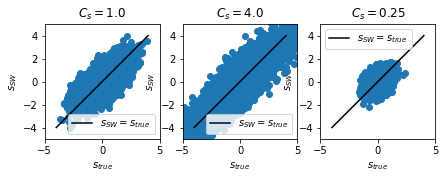

In [5]:
np.random.seed(seed=41)
sarr=[]
weiner=[]
CS=1.
for i in range(10000):
    n=np.random.normal(size=1)
    s=np.sqrt(CS)*np.random.normal(size=1)
    sarr.append(s)
    d=s+n
    w=np.sqrt(CS/(1.+CS))
    weiner.append(d*w)
#plt.plot([1, 2, 3])
# now create a subplot which represents the top plot of a grid
# with 2 rows and 1 column. Since this subplot will overlap the
# first, the plot (and its axes) previously created, will be removed
plt.figure(figsize=(7,7)) 
plt.subplot(131)
ax = plt.gca() #you first need to get the axis handle
ax.set_aspect(1.) #sets the height to width ratio to 1.5. 
plt.scatter(sarr,weiner)  
plt.plot([-4,4],[-4,4],'-k',label='$s_{SW}=s_{true}$')
#plt.plot([-4,4],[-4*w,4*w],'--r',label='$s_{SW}=$'+str(w)+'$s_{true}$')
plt.axis([-5,5,-5,5])
plt.xlabel('$s_{true}$')
plt.ylabel('$s_{SW}$')
plt.title('$C_s=$'+str(CS))
plt.legend()

### Higher CS
sarr=[]
weiner=[]
CS=4.
for i in range(10000):
    n=np.random.normal(size=1)
    s=np.sqrt(CS)*np.random.normal(size=1)
    sarr.append(s)
    d=s+n
    w=np.sqrt(CS/(1.+CS))
    weiner.append(d*w)
#plt.plot([1, 2, 3])
# now create a subplot which represents the top plot of a grid
# with 2 rows and 1 column. Since this subplot will overlap the
# first, the plot (and its axes) previously created, will be removed
#plt.figure(figsize=(7,7)) 
plt.subplot(132)
ax = plt.gca() #you first need to get the axis handle
ax.set_aspect(1.) #sets the height to width ratio to 1.5. 
plt.axis([-5,5,-5,5])
plt.scatter(sarr,weiner)  
plt.plot([-4,4],[-4,4],'-k',label='$s_{SW}=s_{true}$')
#plt.plot([-4,4],[-4*w,4*w],'--r',label='$s_{SW}=$'+str(w)+'$s_{true}$')
plt.xlabel('$s_{true}$')
plt.ylabel('$s_{SW}$')
plt.title('$C_s=$'+str(CS))
plt.legend()

### Lower CS
sarr=[]
weiner=[]
CS=.25
for i in range(10000):
    n=np.random.normal(size=1)
    s=np.sqrt(CS)*np.random.normal(size=1)
    sarr.append(s)
    d=s+n
    w=np.sqrt(CS/(1.+CS))
    weiner.append(d*w)
#plt.plot([1, 2, 3])
# now create a subplot which represents the top plot of a grid
# with 2 rows and 1 column. Since this subplot will overlap the
# first, the plot (and its axes) previously created, will be removed
#plt.figure(figsize=(7,7)) 
plt.subplot(133)
plt.axis([-5,5,-5,5])
ax = plt.gca() #you first need to get the axis handle
ax.set_aspect(1.) #sets the height to width ratio to 1.5. 
plt.scatter(sarr,weiner)  
plt.plot([-4,4],[-4,4],'-k',label='$s_{SW}=s_{true}$')
#plt.plot([-4,4],[-4*w,4*w],'--r',label='$s_{SW}=$'+str(w)+'$s_{true}$')
plt.xlabel('$s_{true}$')
plt.ylabel('$s_{SW}$')
plt.title('$C_s=$'+str(CS))
plt.legend()

So we have this odd situation, where the maximum posterior solution does not match the input signal when averaging over noise; the expectation is if you {\it correct} that by unmultiplying by the Weiner filer, you would get the correct signal back, but instead you end up over-correcting. And then, if you choose the middle path of the square root of the Weiner filter, you actually get an unbiased result.

At this point, it might be helpful to look at histograms of these estimators to see how large the spread is. Let's focus only on the low signal to noise case.

Text(0.5, 0, '$s_{true}$')

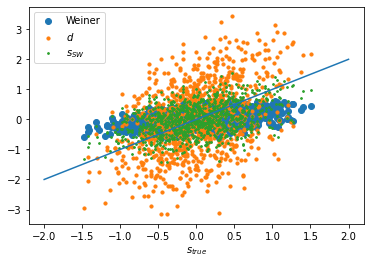

In [6]:
np.random.seed(seed=41)
sarr=[]
weiner=[]
sqweiner=[]
data=[]
CS=.25
for i in range(1000):
    n=np.random.normal(size=1)
    s=np.sqrt(CS)*np.random.normal(size=1)
    sarr.append(s)
    d=s+n
    data.append(d)
    w=d*CS/(1.+CS)
    sw=d*np.sqrt(CS/(1.+CS))
    weiner.append(w)
    sqweiner.append(sw)
plt.scatter(sarr,weiner,label='Weiner')
plt.scatter(sarr,data,label='$d$',s=10)
plt.scatter(sarr,sqweiner,label='$s_{SW}$',s=3)
plt.plot([-2,2],[-2,2])
plt.legend()
plt.xlabel('$s_{true}$')

1.0830123323477125 0.2124226600480661 0.3032090138626248


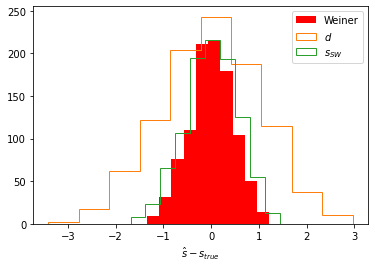

In [7]:
weiner=np.array(weiner)
sqweiner=np.array(sqweiner)
data=np.array(data)
sarr=np.array(sarr)
dw=weiner-sarr
dd=data-sarr
dsw=sqweiner-sarr
plt.hist(dw,facecolor='r',label='Weiner')
plt.hist(dd,histtype='step',facecolor='blue',label='$d$')
plt.hist(dsw,histtype='step',facecolor='k',label='$s_{SW}$')
plt.legend()
plt.xlabel('$\hat s-s_{true}$')
print(np.std(dd)**2,np.std(dw)**2,np.std(dsw)**2)

There it is: the variance of the Weiner filter is much lower than the variance of the data as an estimator. So, even though the data seems to track the signal better, as indicated by the figure above, the Weiner filter has a lower variance. Had you just guessed 0 for all signal draws, you would have gotten the correct mean and a variance of 0.25. So, even in the face of noise which is much larger than the signal, the Weiner filter gets a variance lower than the true variance. Just choosing the data as the estimator allows for very large signal, much larger than the prior would allow. So, the Weiner filter tells us that if you get a given data point, there is not that much that can be learned about the signal from that point. It is slightly informative, in that it reduces the variance of the difference between estimated and true from 0.25 to 0.21.

It might also be interesting to look at the correlation coefficient:
$$ r\equiv \frac{\hat s\cdot s_{True}}{[(\hat s)^2 (s_{True})^2]^{1/2}}$$

In [8]:
def r(hats,strue):
    num=np.dot(hats,strue)
    den=np.sqrt(np.dot(hats,hats)*np.dot(strue,strue))
    return num/den
print(np.shape(weiner),np.shape(sarr))
print(r(weiner[:,0],sarr[:,0]))
print(r(data[:,0],sarr[:,0]))
print(r(sqweiner[:,0],sarr[:,0]))
sdotn=np.dot(sarr[:,0],data[:,0]-sarr[:,0])/1000.
ssq=np.dot(sarr[:,0],sarr[:,0])/1000.
print((CS/(CS+1.))**.5)

(1000, 1) (1000, 1)
0.41292623214236995
0.41292623214236995
0.4129262321423702
0.4472135954999579


So the correlation between any of these estimators is the same. Any linear estimator (at least in this simple 1-pixel case) correlates the same with the truth. Note that the numerator and denominator differ: for the Weiner filter, the cross-correlation is small but so is the noise. But this implies that any linear map can be cross-correlated against a truth map and you would get the same signal to noise.

## Machine Learning

Take the above 1000 points and use them as test data, first training on a large set of pairs.

In [9]:
X_test=data
y_test=sarr
CS=.25
X_train=[]
y_train=[]
for i in range(10000):
    n=np.random.normal(size=1)
    s=np.sqrt(CS)*np.random.normal(size=1)
    y_train.append(s)
    d=s+n
    X_train.append(d)
X_train=np.array(X_train)
y_train=np.array(y_train)
    


In [10]:
# Simplest is just to do regression.
from sklearn.linear_model import LinearRegression
lin_reg=LinearRegression()
lin_reg.fit(X_train,y_train)
regfit=lin_reg.predict(X_test)

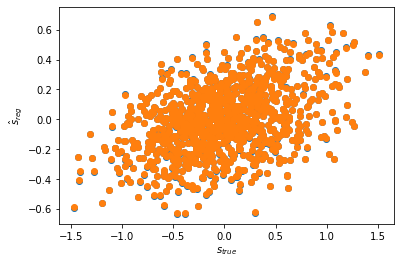

In [11]:
plt.scatter(y_test,regfit)
plt.xlabel('$s_{true}$')
plt.ylabel('$\hat s_{reg}$')
plt.scatter(y_test,weiner)

0.16862274078671924 0.16903914098488315


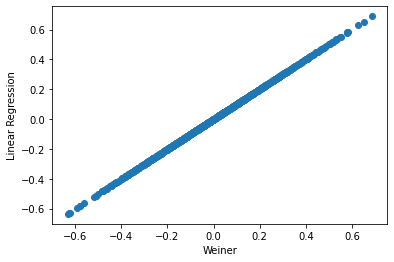

In [12]:
plt.scatter(weiner, regfit)
plt.xlabel('Weiner')
plt.ylabel('Linear Regression')
print(lin_reg.score(X_test,y_test),1.-np.std(dw)**2/np.std(sarr)**2)
#The coefficient of determination  is defined as (1-u/v) 
#where u is the residual sum of squares ((y_true - y_pred)** 2).sum() 
# and v is the total sum of squares ((y_true - y_true.mean()) ** 2).sum()
## In this case v=C_sN and u=0.21N, so 

So, the linear regression is equivalent to the Weiner filter. In some sense this is not surprising, as the Weiner filter minimizes the argument of the exponential, thereby producing a linear fit that minimizes the cost function. The cost function here $$(s-\hat s)^2$$ is proportional to the exponential of the likelihood, so it makes sense that this gives the same answer as the Weiner filter.

In [ ]:
# Now try a neural net
#import tensorflow as tf
from tensorflow import keras
model=keras.models.Sequential()

ValueError: x and y must be the same size

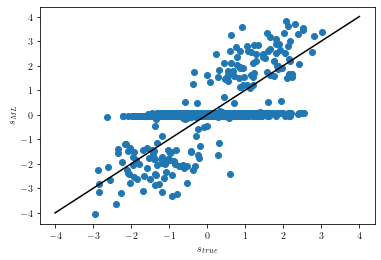

In [192]:
np.random.seed(seed=41)
xml=[]
sarr=[]
csarr=[]
rat=[]
weiner=[]
for i in range(1000):
    n=np.random.normal(size=1)
    s=np.random.normal(size=1)
    sarr.append(s)
    d=s+n
    weiner.append(d/2)
    x0=[1,2]
    fmin = op.minimize(log_prob,x0)
    tmp=fmin.x[0]
    rat.append(tmp/s)
    xml.append(tmp)
    tmp=fmin.x[1]
    csarr.append(tmp)
plt.scatter(sarr,xml,label='$C_s=1$')  
plt.plot([-4,4],[-4,4],'-k')
plt.xlabel('$s_{true}$')
plt.ylabel('$s_{ML}$')
## Higher C_s
xml=[]
sarr1=[]
csarr1=[]
rat=[]
weiner1=[]
sigma=2.
for i in range(100):
    n=np.random.normal(size=1)
    s=sigma*np.random.normal(size=1)
    sarr1.append(s)
    d=s+n
    weiner1.append(d*4/5.)
    x0=[1,2]
    fmin = op.minimize(log_prob,x0)
    tmp=fmin.x[0]
    rat.append(tmp/s)
    xml.append(tmp)
    tmp=fmin.x[1]
    csarr1.append(tmp)
plt.scatter(sarr,xml,label='$C_s=4$') 
plt.axis([-4,4,-4,4])
plt.legend()
plt.savefig('ss.png')


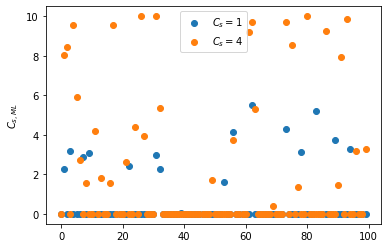

In [46]:
plt.scatter(range(100),csarr,label='$C_s=1$')
plt.scatter(range(100),csarr1,label='$C_s=4$')
plt.ylabel('$C_{s,ML}$')
plt.legend()
plt.savefig('cs.png')
#plt.plot([0,100],[4,4])

In [78]:
### The Weiner filter using the true value of $C_s$ is
## s=d/2 or 4d/5, so that the estimated power spectrum would 
##plt.scatter(rat,csarr)
print(np.mean(csarr))
print(np.mean(rat))

0.5020123987021704
0.4820168149900555


The Weiner filter using the true value of $C_s$ sets $s=d/2$ or $4d/5$ in the two cases above. Let's see how well this does in estimating the signal.

In [130]:
np.random.seed(seed=41)
xml=[]
sarr=[]
csarr=[]
rat=[]
weiner=[]
for i in range(10000):
    n=np.random.normal(size=1)
    s=np.random.normal(size=1)
    sarr.append(s)
    d=s+n
    weiner.append(d/2)
    

Text(0, 0.5, '$s_{Weiner}$')

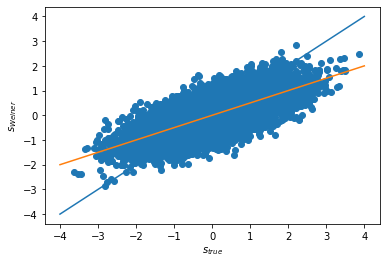

In [133]:
plt.scatter(sarr,weiner,label='$C_s=C_n$')
plt.plot([-4,4],[-4,4])
plt.plot([-4,4],[-2,2])
plt.xlabel('$s_{true}$')
plt.ylabel('$s_{Weiner}$')


It gets the slope wrong, obviously, with mean $\hat s=sC_s/C$. This is the point of maximum likelihood. However, it is interesting to plot the full likelihood.

In [134]:
##low CS
np.random.seed(seed=41)
xml=[]
sarr=[]
csarr=[]
rat=[]
weiner=[]
CS=.1**2
for i in range(10000):
    n=np.random.normal(size=1)
    s=.1*np.random.normal(size=1)
    sarr.append(s)
    d=s+n
    weiner.append(d*CS/(1.+CS))
    

Text(0, 0.5, '$s_{Weiner}$')

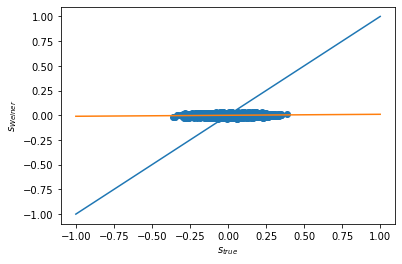

In [136]:
plt.scatter(sarr,weiner,label='$C_s=0.01C_n$')
plt.plot([-1,1],[-1,1])
plt.plot([-1,1],[-.01,.01])
plt.xlabel('$s_{true}$')
plt.ylabel('$s_{Weiner}$')


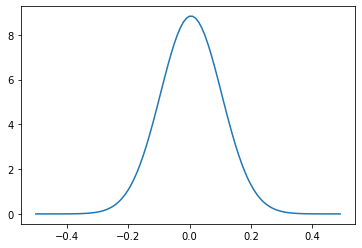

In [140]:
CN=1.
CS=.01
d=.5
def prob(x):
    s=x
    return CS**(-0.5)*np.exp(-0.5*s**2/CS - 0.5*(s-d)**2/CN)
xa=np.arange(-.5,.5,.01)
plt.plot(xa,prob(xa))

The product of 2 gaussians is a gaussian but the peak of the ensuing gaussian is in between $d$ and $0$. In real life the signal can be larger than the data when the noise is negative, but the Weiner filter does not allow for this. So, the maximum likelihood is skewed low.

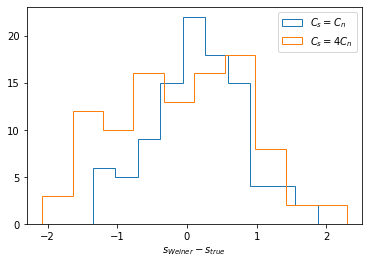

In [105]:
weiner=np.array(weiner)
sarr=np.array(sarr)
weiner1=np.array(weiner1)
sarr1=np.array(sarr1)
plt.hist(weiner-sarr,histtype='step',label='$C_s=C_n$')
plt.hist(weiner1-sarr1,label='$C_s=4C_n$',histtype='step')
plt.legend()
plt.xlabel('$s_{Weiner}-s_{true}$')
plt.savefig('swein.png')

This means that the estimated power spectrum in these two cases would be $d^2 [1/4,16/25]$. We can do a histogram of those predictions.

0.5297018979270384 0.7342915517167761


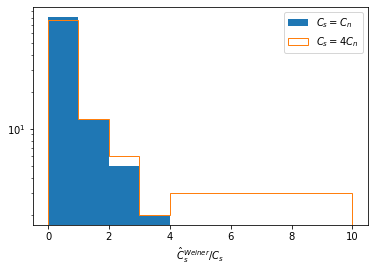

In [112]:
weiner=np.array(weiner)
wbins=[0,1,2,3,4,10]
plt.hist(weiner**2,bins=wbins,label='$C_s=C_n$')
weiner1=np.array(weiner1)
plt.hist(weiner1**2/4,histtype='step',bins=wbins,label='$C_s=4C_n$')
plt.yscale('log')
plt.xlabel('$\hat C_s^{Weiner}/C_s$')
plt.savefig('wpow.png')
plt.legend()
print(np.mean(weiner**2),np.mean(weiner1**2)/4.)

The correct way to estimate the power is to use: $\hat C_s=d^2-C_n$. We can see how well that does here.

1.1188075917081535 0.8973305495574629


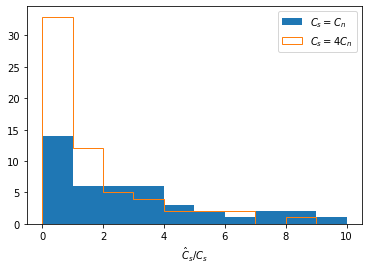

In [115]:
wbins=[0,1,2,3,4,5,6,7,8,9,10]
pow0=weiner**2*4-1.
plt.hist(pow0,bins=wbins,label='$C_s=C_n$')
pow1=((25./16)*weiner1**2-1.)/4
plt.hist(pow1,histtype='step',bins=wbins,label='$C_s=4C_n$')
#plt.yscale('log')
plt.xlabel('$\hat C_s/C_s$')
plt.legend()
plt.savefig('pow.png')
print(np.mean(pow0),np.mean(pow1))

In [3]:
nwalkers = 32
ndim=2
CN=1.
d=1.
p0 = np.zeros((nwalkers,ndim))#[d,CN]
np.random.seed(42)
p0[:,0]=d + np.random.rand(nwalkers)
p0[:,1]=CN + .2*np.random.rand(nwalkers)
print(np.shape(p0))
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob, args=[d,CN])


(32, 2)


In [96]:
state = sampler.run_mcmc(p0, 100)
sampler.reset()

In [97]:
sampler.run_mcmc(state,100000);

None


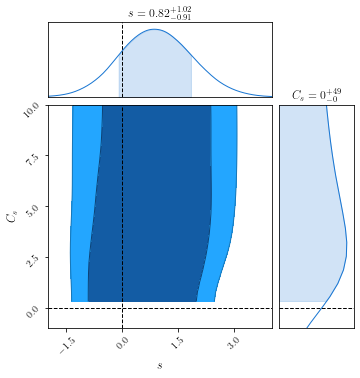

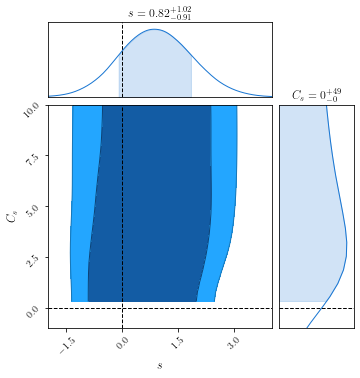

In [100]:
flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)
c = ChainConsumer()
c.add_chain(flat_samples, parameters=["$s$", "$C_s$"],walkers=32)
print(c.analysis.get_max_posteriors(parameters=["$s$", "$C_s$"]))
#c.add_marker(location=[1,4],marker_style='X',marker_size=40)
c.plotter.plot(filename="l1.png", extents=[(-2,4),(-1,10)],figsize="column",truth=[0,0],legend=None)


In [92]:
estp=.5*(d**2-2. + d*np.sqrt(d**2-4.))
print(estp)
estm=.5*(d**2-2. - d*np.sqrt(d**2-4.))
print(estm)

print(log_prob((np.sqrt(estp),estp), d, CN))
print(log_prob((np.sqrt(estm),estm), d, CN))
print(log_prob((2.38,6.1), d, CN))
print(d**2-CN)

4.0
0.25
-1.3181471805599454
-1.8068528194400546
-1.375639467556846
5.25


In [133]:
np.random.seed(seed=42)
n=np.random.normal(size=2)
s=np.random.normal(size=2)
d=s+n
print(d)

[1.14440269 1.38476556]


In [58]:
CN=1.
def log_2dprob(x, d):
    s=x[:2]
    CS=x[2]
    if CS <= .0001 or CS >= 10.:
        return -100
    else:
        return -0.5*np.log(CS**2) - 0.5*np.dot(s,s)/CS - 0.5*np.dot((s-d),s-d)/CN
def log_2dprob_minus(x, d):
    s=x[:2]
    CS=x[2]
    if CS <= .0001 or CS >= 10.:
        return 100
    else:
        return 0.5*np.log(CS**2) + 0.5*np.dot(s,s)/CS + 0.5*np.dot((s-d),s-d)/CN


In [182]:
nwalkers = 32
ndim=3
p0 = np.zeros((nwalkers,ndim))#[d,CN]
np.random.seed(42)
p0[:,0]=np.random.rand(nwalkers)
p0[:,1]=np.random.rand(nwalkers)
p0[:,2]=(1.+.01*np.random.rand(nwalkers))
print(p0[:,2])
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_2dprob, args=[d])
state = sampler.run_mcmc(p0, 100)
sampler.reset()

[1.00280935 1.00542696 1.00140924 1.00802197 1.00074551 1.00986887
 1.00772245 1.00198716 1.00005522 1.00815461 1.00706857 1.00729007
 1.0077127  1.00074045 1.00358466 1.00115869 1.00863103 1.00623298
 1.00330898 1.00063558 1.00310982 1.00325183 1.00729606 1.00637557
 1.00887213 1.00472215 1.00119594 1.00713245 1.00760785 1.00561277
 1.00770967 1.00493796]


In [183]:
sampler.run_mcmc(state,200000)

State([[ 3.35853062e+00  2.48791596e+00  5.86741943e+00]
 [ 2.39582628e+00  1.28981547e+00  2.63513523e+00]
 [ 7.44097104e-01  1.25542905e+00  2.29433541e+00]
 [-1.22712798e+00  2.25121847e-01  9.09531895e+00]
 [ 5.60283694e-01  1.41319535e+00  6.28078096e+00]
 [-1.39553351e+00  7.11698922e-01  1.57488414e+00]
 [ 2.97036050e-01  1.38774705e-01  1.26395094e-01]
 [ 2.48696118e+00 -3.24166978e-01  5.11380040e+00]
 [-5.29975450e-01 -3.58720423e-01  5.29420553e+00]
 [-4.08380155e-02  4.11251361e-01  1.31068590e+00]
 [ 4.40944949e-01 -2.24412254e-01  6.25021234e-01]
 [ 3.96230802e-01  4.87225208e-01  3.33796528e+00]
 [ 1.19404224e+00  1.47897187e+00  7.54433587e+00]
 [ 4.97111793e-01  2.22713067e+00  2.48105284e+00]
 [ 1.28098319e+00  6.28312478e-01  5.85261286e+00]
 [ 9.54488952e-01  6.69067239e-01  9.93746150e+00]
 [ 2.05202186e-01  8.96009293e-01  7.95814953e+00]
 [ 9.85860306e-01  6.94313059e-01  4.17407700e+00]
 [ 6.19024716e-01 -1.80983187e-02  9.13892467e-01]
 [ 7.05525552e-01  9.6919

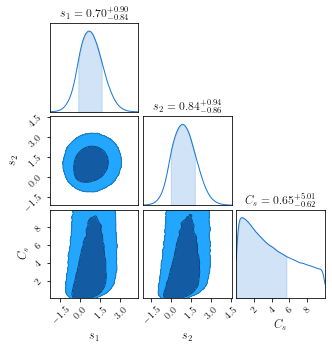

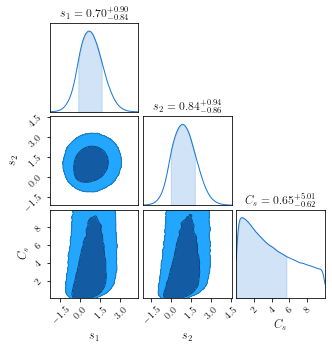

In [187]:
flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)
c = ChainConsumer()
c.add_chain(flat_samples, parameters=["$s_1$", "$s_2$","$C_s$"])
maxp=[d[0]/2.,d[1]/2.,1.]
c.plotter.plot(filename="3d.png")#,truth=maxp)#,figsize="column",truth=[0,0],legend=None)


In [60]:
print(d)
bard=0.5*np.dot(d,d)
print(bard)
#estp=.5*(bard**2-2. + bard*np.sqrt(bard**2-4.))
#print(estp)
#estm=.5*(bard**2-2. - bard*np.sqrt(bard**2-4.))
#print(estm)

print(log_2dprob([0.,0.,.011], d))
print(log_2dprob([0.7,0.84,.65], d))
#print(log_prob((np.sqrt(estm),estm), d, CN))
#print(log_prob((2.38,6.1), d, CN))


[2.36109278]
2.787379554801199
-1.0648991034186315
-3.0253856220130206


In [77]:
x0=[.1,.1,.5]
fmin = op.minimize((log_2dprob_minus),x0,args=d)#,method='Powell')
print(fmin)

      fun: -0.5144597248001181
 hess_inv: array([[4.17161790e-02, 2.41373667e-01, 1.74189249e-03],
       [2.41373667e-01, 1.44311916e+00, 1.03876928e-02],
       [1.74189249e-03, 1.03876928e-02, 7.47887401e-05]])
      jac: array([   154.79857302,    185.89691752, -20538.55127841])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 381
      nit: 15
     njev: 93
   status: 2
  success: False
        x: array([0.01650379, 0.01976951, 0.00010502])


In [67]:
print(log_2dprob_minus([1.80800108, 1.80799628, 3.26890828],d))
print(log_2dprob_minus([0.1,0.1,.011],d))

2.4903541458930247
1.5117714567706786
